# US President Classifier

The Downloads_President notebook contains the code for downloading the images from google. Obama_Trump_Classification contains a simple example with differentiating Obama vs Trump.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import random

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

assert torch.cuda.is_available() & torch.backends.cudnn.enabled

PATH = "data/presidents/"
PATH_TRAIN = PATH+'train/'

assert os.path.exists(PATH_TRAIN)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
labels = pd.read_csv(PATH+'labels.csv')

In [3]:
n = len(labels.index)
val_idxs = get_cv_idxs(n, seed = 101)
(n, len(val_idxs))

(2707, 541)

In [4]:
labels.head()

,id,label
0,President_Millard_Fillmore46.jpg,President_Millard_Fillmore
1,President_Millard_Fillmore35.jpg,President_Millard_Fillmore
2,President_Millard_Fillmore8.jpg,President_Millard_Fillmore
3,President_Millard_Fillmore0.jpg,President_Millard_Fillmore
4,President_Millard_Fillmore7.jpg,President_Millard_Fillmore


## Initial Model

In [5]:
def get_data(sz, bs = 32): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', val_idxs=val_idxs, 
                                        suffix='', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [6]:
# Let's start with small images
sz = 128
arch = resnet34
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True)  # Start with precompute = True

In [7]:
learn.lr_find()

  1%|▏         | 1/68 [00:01<01:13,  1.10s/it, loss=4.14]


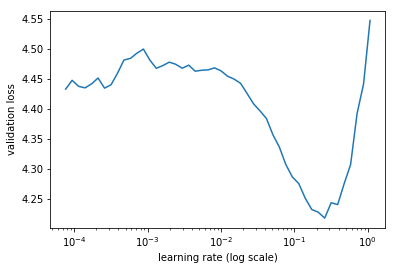

In [8]:
learn.sched.plot()

In [9]:
lr = 1e-1

In [10]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      3.971062   3.229222   0.120148  
    1      3.113007   3.011616   0.177449                 



[array([3.01162]), 0.1774491679591304]

Okay, results are terrible so far.

In [11]:
learn.precompute = False

In [12]:
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                  
    0      2.804086   2.803381   0.231054  
    1      2.819374   2.857033   0.190388                  
    2      2.541188   2.747344   0.232902                  
    3      2.709982   2.897707   0.212569                  
    4      2.610823   2.766474   0.231054                  
    5      2.357891   2.677047   0.266174                  
    6      2.184003   2.652976   0.256932                  



[array([2.65298]), 0.25693160788519326]

In [13]:
learn.save('presidents_v1')

## Increase size

In [56]:
learn.load('presidents_v1')

In [57]:
sz = 224

In [58]:
learn.set_data(get_data(sz))

In [59]:
learn.fit(lr, 1, cycle_len = 2)

epoch      trn_loss   val_loss   accuracy                  
    0      2.671434   2.615394   0.268022  
    1      2.339475   2.508362   0.303142                  


[array([2.50836]), 0.3031423287448954]

In [60]:
sz = 299
learn.set_data(get_data(sz))

In [61]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      2.503594   2.528784   0.301294  
    1      2.530247   2.538181   0.284658                  
    2      2.207053   2.408721   0.330869                  


[array([2.40872]), 0.33086876149759276]

In [62]:
learn.save('presidents_v2')

## Unfreeze layers

In [68]:
learn.load('presidents_v2')

In [69]:
learn.unfreeze()

 94%|█████████▍| 64/68 [00:27<00:01,  2.35it/s, loss=8.52]

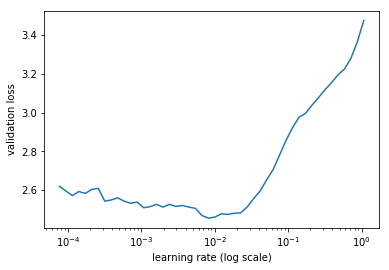

In [70]:
learn.lr_find()
learn.sched.plot()

In [71]:
lr = 1e-3
lrs = [lr, lr/5, lr/25]

In [72]:
learn.fit(lrs, 1, cycle_len = 4)

epoch      trn_loss   val_loss   accuracy                  
    0      2.339955   2.65025    0.271719  
    1      2.113145   2.296057   0.347505                  
    2      1.937568   2.233104   0.367837                  
    3      1.871656   2.214991   0.365989                  


[array([2.21499]), 0.3659889093718996]

## Analyze Results

In [73]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds)
y = data.val_y

In [75]:
data.classes[:10]

['President_Abraham_Lincoln',
 'President_Andrew_Jackson',
 'President_Andrew_Johnson',
 'President_Barack_Hussein_Obama',
 'President_Benjamin_Harrison',
 'President_Bill_Clinton',
 'President_Calvin_Coolidge',
 'President_Chester_A._Arthur',
 'President_Donald_J._Trump',
 'President_Dwight_D._Eisenhower']

In [77]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def most_by_correct(cat, is_correct = True, num = 4): 
    mask = ((preds == data.val_y)==is_correct) & (data.val_y == cat)
    idxs = np.where(mask, )[0]
    mult = -1 if is_correct else 1
    return idxs[np.argsort(mult*probs[:, cat][idxs])[:num]]

def plot_val_with_title(cat, is_correct = True, title = '', num = 4):
    idxs = most_by_correct(cat, is_correct, num)
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[:, cat][x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Most Correct Abraham Lincoln Pics


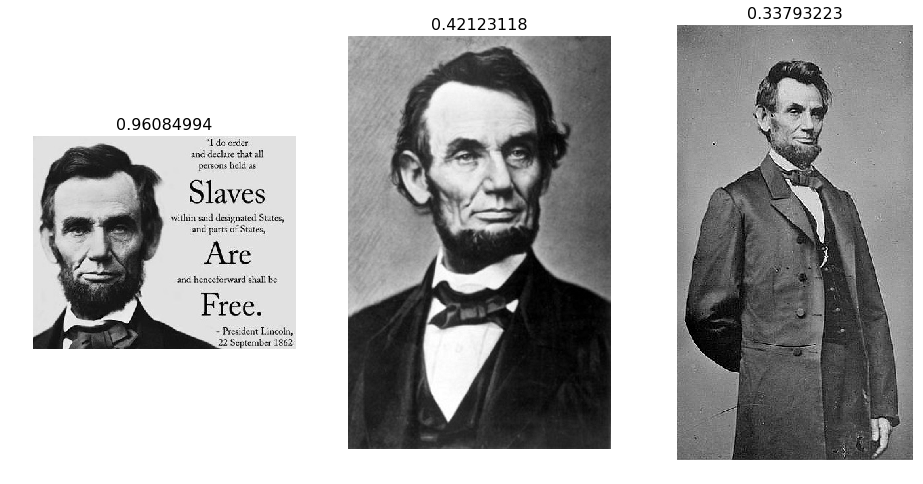

In [78]:
plot_val_with_title(0, True, 'Most Correct Abraham Lincoln Pics')

Looks like we only have 1 correct predictions! Not good.

Most Incorrect Abraham Lincoln Pics


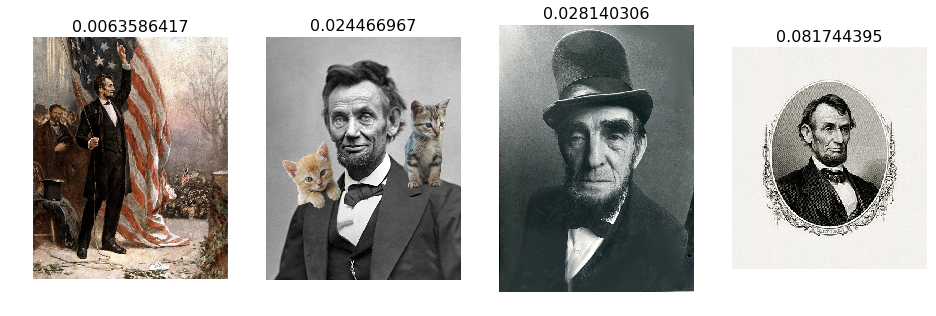

In [79]:
plot_val_with_title(0, False, 'Most Incorrect Abraham Lincoln Pics')

Most Correct Donald Trump Pics


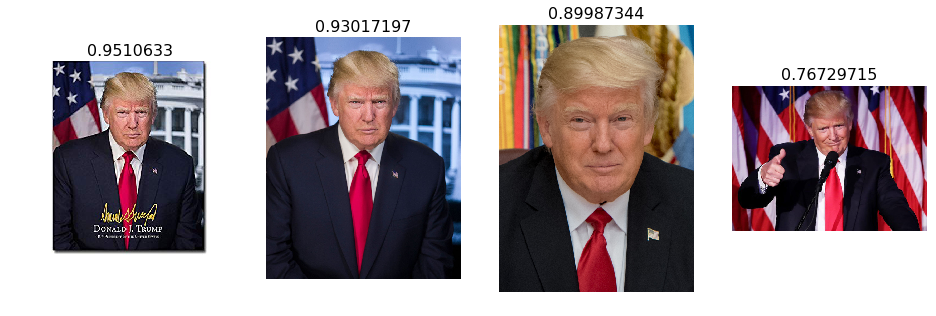

In [80]:
plot_val_with_title(8, True, 'Most Correct Donald Trump Pics')

Most Incorrect Donald Trump Pics


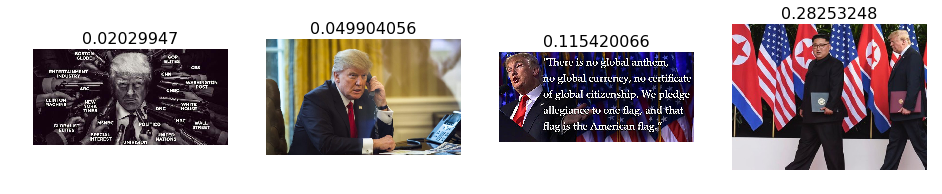

In [82]:
plot_val_with_title(8, False, 'Most Incorrect Donald Trump Pics')